# Neural Networks using PyTorch

# Basics of neural network modeling 

1. Define the dataset
2. Define the model
3. Define the loss function
4. Optimize
5. Predict or Generate

# Generate training data

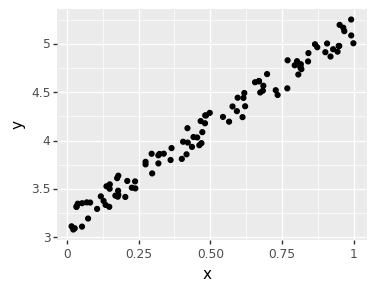

<ggplot: (8754271888353)>

In [1]:
import numpy as np
import pandas as pd
from plotnine import *
import plotnine
plotnine.options.figure_size = (4, 3)

# initialize RNG
np.random.seed(111)

# normal with mean 0 and std 1
x = np.random.rand(100, 1)

# linear with Gaussian noise
y = 3 + 2 * x  + 0.3 * np.random.rand(100, 1)

# visualize
data = pd.DataFrame({"x": x.flatten(), "y" : y.flatten()})
(ggplot(data, aes(x="x", y="y")) +
 geom_point())

# 80:20 split into training and validation sets

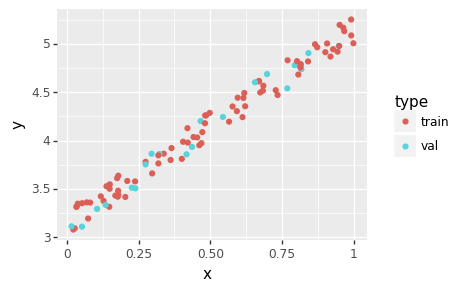

<ggplot: (8754267402805)>

In [2]:
idx = np.arange(100)
# randomly shuffle indices
np.random.shuffle(idx)

# Uses first 80 random indices for train
train_idx = idx[:80]
# Uses the remaining indices for validation
val_idx = idx[80:]

# Generates train and validation sets
x_train, y_train = x[train_idx], y[train_idx]
x_val, y_val = x[val_idx], y[val_idx]

# Visualize the split
data.loc[train_idx, "type"] = "train"
data.loc[val_idx, "type"] = "val"
(ggplot(data, aes(x="x", y="y", color="type")) +
 geom_point())

# Define neuron and network model

<center><img src="img/linear_node.svg"></center>

# Gradient descent with mean square loss

In [3]:
# Pick random model parameters
W = np.random.rand(1)
b = np.random.rand(1)
print(f'W_initial = {W[0]}, b_initial = {b[0]}')

# learning rate
lr = 0.1
# cycles of training
n_epochs = 300

progress = list()
for epoch in range(n_epochs):
    # Model prediction
    yhat = W * x_train + b    
    # Prediction error
    error = (y_train - yhat)    
    # Mean-squared loss
    loss = (error ** 2).mean()
    
    # Computes gradients of loss w.r.t W and b
    b_grad = -2 * error.mean()
    W_grad = -2 * (x_train * error).mean()
    
    # Updates parameters using gradients and the learning rate
    b = b - lr * b_grad
    W = W - lr * W_grad    
    progress.append({"loss": loss, "W": W[0], "b": b[0]})   
print(f'W_final = {W[0]}, b_final = {b[0]}')

W_initial = 0.9479810846140565, b_initial = 0.45991457711803496
W_final = 1.9972489673577787, b_final = 3.159498642845708


# Change in model parameters and loss with training

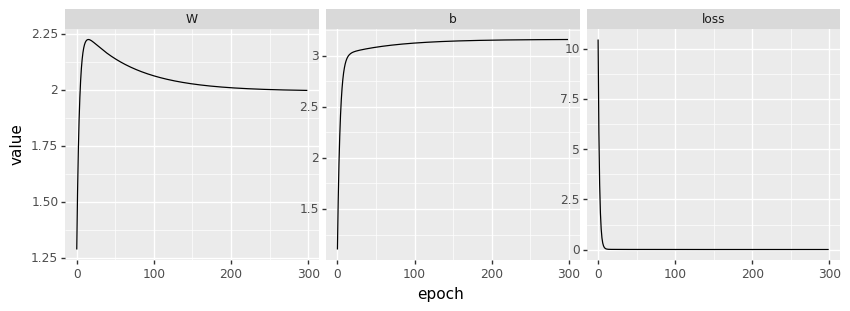

<ggplot: (8754267382629)>

In [4]:
progress_df = pd.DataFrame(progress).reset_index().rename({"index": "epoch"}, axis=1)

progress_df = progress_df.melt(id_vars = 'epoch')

plotnine.options.figure_size = (10, 3)
(ggplot(progress_df, aes(x='epoch', y='value')) + 
 facet_wrap('~ variable', scales = 'free') + 
 geom_line())

# PyTorch implementation

Select GPU vs. CPU

In [1]:
import torch

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.get_device_name()

'Quadro P4000'

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


# Change `numpy` arrays to `torch` tensors 

In [9]:
print(x_train.shape)
print(type(x_train))

(80, 1)
<class 'numpy.ndarray'>


In [10]:
x_train_tensor = torch.Tensor(x_train).to(device)
y_train_tensor = torch.Tensor(y_train).to(device)
print(x_train_tensor.shape)
print(x_train_tensor.type())

torch.Size([80, 1])
torch.cuda.FloatTensor


See [`torch.Tensor`](https://pytorch.org/docs/stable/tensors.html) for all `Tensor` types.

# Specify automatic gradients for model parameters

In [11]:
torch.manual_seed(111)
W = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

# Same as before but automatic gradients

In [12]:
torch.manual_seed(111)
W = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

print(f'W_initial = {W.item()}, b_initial = {b.item()}')

# learning rate
lr = 0.1
# cycles of training
n_epochs = 300

progress = list()
for epoch in range(n_epochs):
    # Model prediction
    yhat = W * x_train_tensor + b    
    # Prediction error
    error = (y_train_tensor - yhat)    
    # Mean-squared loss
    loss = (error ** 2).mean()
    
#     # Computes gradients of loss w.r.t W and b
#     b_grad = -2 * error.mean()
#     W_grad = -2 * (x_train * error).mean()
    # Autograd instead of above manual grad
    loss.backward()
        
    # Updates parameters using gradients and the learning rate
    with torch.no_grad():
        b -= lr * b.grad
        W -= lr * W.grad
        
    b.grad.zero_()
    W.grad.zero_()    
    
    progress.append({"loss": loss.item(), "W": W.item(), "b": b.item()})  
    
print(f'W_final = {W.item()}, b_final = {b.item()}')

W_initial = -2.289983034133911, b_initial = -1.1539770364761353
W_final = 1.9762195348739624, b_final = 3.170736312866211


# Change in model parameters and loss with training

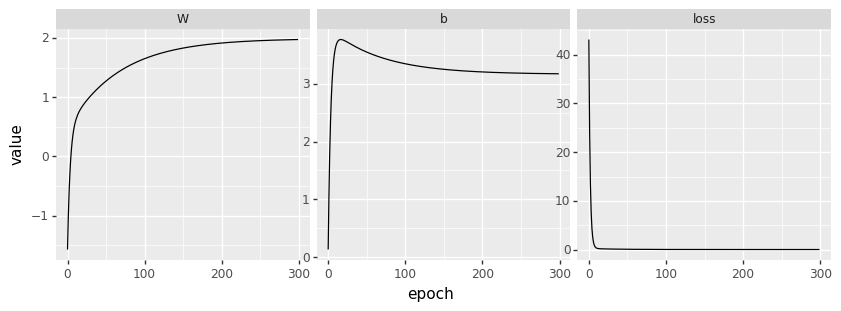

<ggplot: (8754186710909)>

In [13]:
progress_df = pd.DataFrame(progress).reset_index().rename({"index": "epoch"}, axis=1)

progress_df = progress_df.melt(id_vars = 'epoch')

plotnine.options.figure_size = (10, 3)
(ggplot(progress_df, aes(x='epoch', y='value')) + 
 facet_wrap('~ variable', scales = 'free') + 
 geom_line())

# Lots of syntactic sugar

# `Optimizer` class for gradient descent and resetting gradients after step

eg. [torch.optim.SGD](https://pytorch.org/docs/stable/optim.html)

In [14]:
from torch.optim import SGD

torch.manual_seed(111)
W = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

print(f'W_initial = {W.item()}, b_initial = {b.item()}')

# learning rate
lr = 0.1
# cycles of training
n_epochs = 300

progress = list()

optimizer = SGD([W, b], lr=lr)

for epoch in range(n_epochs):
    # Model prediction
    yhat = W * x_train_tensor + b    
    # Prediction error
    error = (y_train_tensor - yhat)    
    # Mean-squared loss
    loss = (error ** 2).mean()

    loss.backward()
        
#     # Updates parameters using gradients and the learning rate
#     with torch.no_grad():
#         b -= lr * b.grad
#         W -= lr * W.grad
    # Automatic update of parameters
    optimizer.step()
        
#     b.grad.zero_()
#     W.grad.zero_()
    # Automatic reset of gradients
    optimizer.zero_grad()
    
    progress.append({"loss": loss.item(), "W": W.item(), "b": b.item()})  
    
print(f'W_final = {W.item()}, b_final = {b.item()}')

W_initial = -2.289983034133911, b_initial = -1.1539770364761353
W_final = 1.9762195348739624, b_final = 3.170736312866211


# Popular loss functions available out-of-box 

eg. [torch.nn.MSELoss](https://pytorch.org/docs/stable/nn.html#mseloss)

In [15]:
from torch.nn import MSELoss
from torch.optim import SGD

torch.manual_seed(111)
W = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)
b = torch.randn(1, requires_grad=True, dtype=torch.float, device=device)

print(f'W_initial = {W.item()}, b_initial = {b.item()}')

# learning rate
lr = 0.1
# cycles of training
n_epochs = 300

progress = list()

optimizer = SGD([W, b], lr=lr)

loss_fn = MSELoss(reduction='mean')

for epoch in range(n_epochs):
    # Model prediction
    yhat = W * x_train_tensor + b    
#     # Prediction error
#     error = (y_train_tensor - yhat)    
#     # Mean-squared loss
#     loss = (error ** 2).mean()
    # Syntax: loss = loss_fn(input, target)
    loss = loss_fn(yhat, y_train_tensor)

    loss.backward()
        
    optimizer.step()

    optimizer.zero_grad()
    
    progress.append({"loss": loss.item(), "W": W.item(), "b": b.item()})  
    
print(f'W_final = {W.item()}, b_final = {b.item()}')

W_initial = -2.289983034133911, b_initial = -1.1539770364761353
W_final = 1.9762195348739624, b_final = 3.170736312866211


# Popular neuron layers available out-of-box 

eg. [torch.nn.Linear](https://pytorch.org/docs/stable/nn.html#linear)

In [16]:
from torch.nn import Linear
from torch.nn import MSELoss
from torch.optim import SGD

torch.manual_seed(111)

# learning rate
lr = 0.1
# cycles of training
n_epochs = 300

progress = list()

model = Linear(1, 1).to(device)
print(f'W_initial = {model.weight.item()}, b_initial = {model.bias.item()}')

# optimizer = SGD([W, b], lr=lr)
# No need to list parameters
optimizer = SGD(model.parameters(), lr=lr)

loss_fn = MSELoss(reduction='mean')

for epoch in range(n_epochs):
#     # Model prediction
#     yhat = W * x_train_tensor + b    
    # Automatic prediction
    yhat = model(x_train_tensor)
    
    loss = loss_fn(yhat, y_train_tensor)

    loss.backward()
        
    optimizer.step()

    optimizer.zero_grad()
    
    progress.append({"loss": loss.item(), "W": model.weight.item(), "b": model.bias.item()})  
    
print(f'W_final = {model.weight.item()}, b_final = {model.bias.item()}')

W_initial = 0.43113183975219727, b_initial = 0.8279852867126465
W_final = 1.9909327030181885, b_final = 3.1628739833831787


# Training workflow summary

In [17]:
model = Linear(1, 1).to(device)
# Checks model's initial parameters
print(f'W_initial = {model.weight.item()}, b_initial = {model.bias.item()}')

optimizer = SGD(model.parameters(), lr=lr)

loss_fn = MSELoss(reduction='mean')

def make_train_step(model, loss_fn, optimizer):
    # Builds function that performs a step in the train loop
    def train_step(x, y):
        # Makes predictions
        yhat = model(x)
        # Computes loss
        loss = loss_fn(y, yhat)
        # Computes gradients
        loss.backward()
        # Updates parameters and zeroes gradients
        optimizer.step()
        optimizer.zero_grad()
        # Returns the loss
        return loss.item()
    
    # Returns the function that will be called inside the train loop
    return train_step

# Creates the train_step function for our model, loss function and optimizer
train_step = make_train_step(model, loss_fn, optimizer)
losses = list()

# For each epoch...
for epoch in range(n_epochs):
    # Performs one train step and returns the corresponding loss
    loss = train_step(x_train_tensor, y_train_tensor)
    losses.append(loss)
    
# Checks model's final parameters
print(f'W_final = {model.weight.item()}, b_final = {model.bias.item()}')

W_initial = -0.43628454208374023, b_initial = -0.48380041122436523
W_final = 1.9894589185714722, b_final = 3.163661479949951


# Reference

Adapted from [Understanding PyTorch with an example: a step-by-step tutorial](https://towardsdatascience.com/understanding-pytorch-with-an-example-a-step-by-step-tutorial-81fc5f8c4e8e)